In [31]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchmetrics

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
print("Success")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Success


# 선형 회귀 모델

데이터 생성


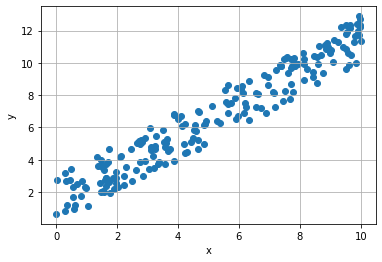

In [6]:
X = torch.rand(200,1) * 10
Y = X + 3*torch.rand(200,1)

plt.scatter(X.numpy(), Y.numpy())
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

모델 정의 및 파라미터

In [33]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super(LinearRegressionModel, self).__init__()
    self.linear = nn.Linear(1,1)

  def forward(self, x):
    pred = self.linear(x)
    return pred

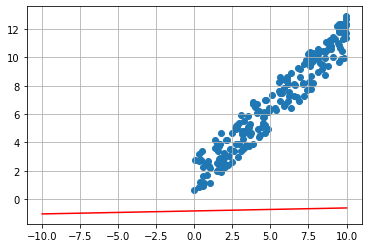

In [34]:
model = LinearRegressionModel()

w, b = model.parameters()

w1= w[0][0].item()
b1 = b[0].item()

x1 = np.array([-10, 10])
y1 = w1*x1 + b1

plt.plot(x1, y1, "r")
plt.scatter(X,Y)
plt.grid()
plt.show()

손실 함수 및 옵티마이저

In [35]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

모델 학습

In [36]:
epochs = 100
losses = []
for epoch in range(epochs):
  optimizer.zero_grad()

  y_pred = model(X)
  loss = criterion(y_pred, Y)
  losses.append(loss.item())
  loss.backward()

  optimizer.step()


Text(0.5, 0, 'Epoch')

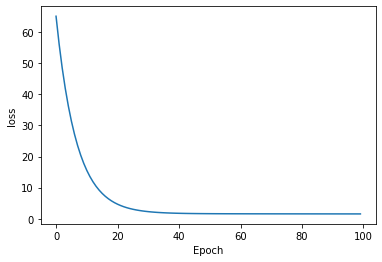

In [37]:
plt.plot(range(epochs), losses)
plt.ylabel("loss")
plt.xlabel("Epoch")

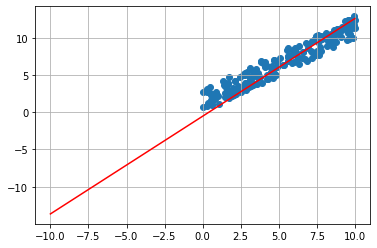

In [39]:
w1= w[0][0].item()
b1 = b[0].item()

x1 = np.array([-10, 10])
y1 = w1*x1 + b1

plt.plot(x1, y1, "r")
plt.scatter(X,Y)
plt.grid()
plt.show()

# FashionMNIST 분류 모델

GPU 설정

In [22]:
device = torch.device("cuda")

데이터 로드

In [23]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))])

trainset = datasets.FashionMNIST(root="/content",
                                 train=True,
                                 download=True,
                                 transform = transform)

testset = datasets.FashionMNIST(root="/content",
                                 train=False,
                                 download=True,
                                 transform = transform)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)


In [24]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
labels_map = {
  0 : "T-shirt",
  1 : "Trouser",
  2 : "Pullover",
  3 : "Dress",
  4 : "Coat",
  5 : "Sandal",
  6 : "Shirt",
  7 : "Sneaker",
  8 : "Bag",
  9 : "Ankel Boot"    
}

figure = plt.figure(figsize = (12,12))
cols, rows = 4,4

for i in range(1, cols*rows+1):
  image = images[i].squeeze()
  label_idx = labels[i].item()
  label = labels_map[label_idx]

  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(image, cmap="gray")

plt.show()

모델 정의 및 파라미터

In [14]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = NeuralNet()
print(net)


NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


손실함수와 옵티마이저

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

모델 학습

In [25]:
total_batch = len(train_loader)
print(total_batch)

469


In [26]:
for epoch in range(10):
  running_loss = 0.0

  for i, data in enumerate(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 100 == 99:
      print(f"Epoch : {epoch}, iter : {i} loss : {running_loss / 2000}")
      running_loss = 0

Epoch : 0, iter : 99 loss : 0.11512845456600189
Epoch : 0, iter : 199 loss : 0.22992933595180512
Epoch : 0, iter : 299 loss : 0.3444144362211227
Epoch : 0, iter : 399 loss : 0.45832374119758607
Epoch : 1, iter : 99 loss : 0.11076619386672974
Epoch : 1, iter : 199 loss : 0.21287989014387132
Epoch : 1, iter : 299 loss : 0.28674403911828994
Epoch : 1, iter : 399 loss : 0.3366131377518177
Epoch : 2, iter : 99 loss : 0.039484355568885805
Epoch : 2, iter : 199 loss : 0.07667002141475678
Epoch : 2, iter : 299 loss : 0.11287679523229599
Epoch : 2, iter : 399 loss : 0.14697532188892365
Epoch : 3, iter : 99 loss : 0.03357001850008964
Epoch : 3, iter : 199 loss : 0.06606837946176529
Epoch : 3, iter : 299 loss : 0.09834035322070121
Epoch : 3, iter : 399 loss : 0.12977460053563117
Epoch : 4, iter : 99 loss : 0.030627130657434463
Epoch : 4, iter : 199 loss : 0.06139970587193966
Epoch : 4, iter : 299 loss : 0.09110628095269203
Epoch : 4, iter : 399 loss : 0.1212572557926178
Epoch : 5, iter : 99 loss 

모델의 저장 및 로드
- torch.save : net.state_dict() 를저장
- torch.load : load_state_dic로 모델을 로드

In [27]:
PATH = "./fashion_mnist.pth"
torch.save(net.state_dict(), PATH)

In [28]:
net = NeuralNet()
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [29]:
net.parameters

<bound method Module.parameters of NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

모델 테스트

In [30]:
def imshow(image):
  image = image / 2 + 0.5
  npimg = image.numpy()

  flg = plt.figure(figsize = (16, 8))
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

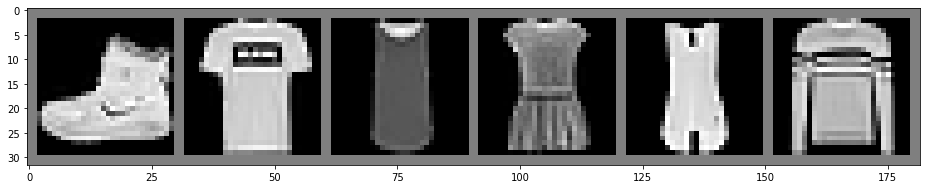

In [33]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:6]))

In [35]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([9, 0, 3, 0, 3, 2, 7, 4, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 2, 4, 3, 1, 4, 8,
        2, 3, 0, 2, 2, 4, 5, 3, 4, 2, 0, 8, 5, 0, 1, 6, 2, 7, 9, 5, 5, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 0, 1, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        0, 3, 1, 4, 4, 0, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        2, 1, 1, 8, 8, 3, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 0, 3, 1, 5, 4, 4, 7,
        5, 5, 9, 2, 2, 6, 7, 1])
torch.Size([128])


In [37]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(100 * correct / total)

82.17666666666666
